# Importing libraries

In [10]:
import torch
import os 
import pickle
import io

# text stuff
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import StaticEmbedding
from sentence_transformers import util
from tokenizers import Tokenizer

# mathy stuff
import numpy as np
import sklearn.metrics
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# plotting stuff 
import matplotlib.pyplot as plt
import seaborn as sns

# setting directory if necessary
# os.chdir("../..")

In [11]:
os.getcwd()

'/Users/jiayilow/Desktop/CASA/Dissertation/mapping_reform'

# Loading data

In [9]:
class CPUUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

# initialising empty dict to store
publication_data = {}

# reading in publication vector pickle files 
for filename in os.listdir("data/article_embeddings/pub_embeddings_norm_mpnet_final"):
    filepath = os.path.join("data/article_embeddings/pub_embeddings_norm_mpnet_final/", filename)
    print(f"Loading data for {filepath}...")
    with open(filepath, "rb") as f:
        data = CPUUnpickler(f).load()
        publication_data[filename] = data

# Prepare lists to hold everything
all_articles = []
all_embeddings = []
all_dates = []
all_sources = []

# loading everything into one structure
for name, pubdata in {
    'ewj': publication_data["the_english_womans_journal.pkl"],
    'star': publication_data["the_northern_star.pkl"],
    'leader': publication_data["the_leader.pkl"],
    'circ': publication_data['the_publishers_circular.pkl'],
    'tomahawk': publication_data['the_tomahawk.pkl'],
    'repo': publication_data['the_monthly_repository.pkl']
}.items():
    all_articles.extend(pubdata['articles'])
    all_embeddings.extend(pubdata['embeddings'])
    all_dates.extend(pubdata['dates'])
    all_sources.extend([name] * len(pubdata['articles']))

Loading data for data/article_embeddings/pub_embeddings_norm_mpnet_final/the_northern_star.pkl...


KeyboardInterrupt: 

# Defining embedding model

In [3]:
# this is the sentencetransformer model im using
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=torch.device('cpu'))

# Functions 

In [4]:
# function for inspecting results of each query experiment:
# this function displays the top_n (default  5) articles ranked by similarity score
# and plots a histogram of scores/count

def topn_plot(df, 
              article_base=all_articles,
              source_base=all_sources,
              dates_base=all_dates,
              top_n=5,
              title="Histogram of Similarity Scores"):
    """
    Displays the top N articles based on similarity score and plots a histogram.

    Parameters:
    - df: DataFrame with columns ['corpus_id', 'score']
    - article_base: dict mapping corpus_id to article text (all_articles for everything)
    - source_base: dict mapping corpus_id to source name (all_sources for everything)
    - dates_base: dict mapping dates_base to source name (all_dates for everything)
    - top_n: number of top articles to display
    - title: title for the histogram
    """
    # Display top N articles
    print(f"\nTop {top_n} Articles:\n")
    for i, row in df.head(top_n).iterrows():
        corpus_id = int(row['corpus_id'])
        score = row['score']
        article_text = all_articles[corpus_id]
        publication = all_sources[corpus_id]
        date = all_dates[corpus_id]

        print(f"\nRank {i + 1}")
        print(f"Score: {score:.4f}")
        print(f"Publication: {publication}")
        print(f"Article:\n{article_text}\n")

    # Plot histogram
    plt.figure(figsize=(10, 6))
    sns.set_theme()
    sns.histplot(data=df, x='score', bins=20, kde=True, alpha=0.6)

    plt.title(title, 
              fontweight='bold',
              fontname='Liberation Sans')
    plt.xlabel("Similarity Score")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Creating query embedding from synthetic articles
1. Generate synthetic articles using LLM
2. Embed articles
3. Calculate mean embedding

## Structuring prompt
I'm focusing on these 8 event types to constitute 'collective action': meeting, public meeting, strike, protest, riot, demonstration, assembly, gathering. Accordingly, my prompt is as follows:
"You are a reporter for a 19th century English newspaper. Write 9 distinct, short (2-3 sentences each) fictional newspaper excerpts spanning the 1800s, one for each type of collective action in the list below. The event should be organised in support of a sociopolitical movement relevant to the time.
1. meeting
2. public meeting
3. strike
4. protest
5. riot
6. demonstration
7. assembly
8. gathering
9. lecture

Each excerpt should report on the event and the geographic location at which it happened. The language should sound authentic to the period. Format output as a list called 'synthetic_articles' containing each generated article as a dictionary with event type and article text as keys."

In [ ]:
# generated synthetic articles, embedding them, and calculating an average

synthetic_articles = [
    {
        "event_type": "meeting",
        "article_text": "A private meeting of the Anti-Corn Law League was held yesterday evening at the residence of Mr. Richard Cobden in Manchester. The assembled gentlemen discussed strategies for the repeal of the odious grain duties that so burden our manufacturing classes."
    },
    {
        "event_type": "public meeting",
        "article_text": "A public meeting in favour of Parliamentary Reform drew considerable crowds to Trafalgar Square on Tuesday last. Mr. John Bright addressed the multitude on the necessity of extending the franchise to the respectable working classes of our nation."
    },
    {
        "event_type": "strike",
        "article_text": "The mill workers of Preston have withdrawn their labour in a most determined strike against the reduction of wages proposed by their masters. Above three thousand operatives have ceased work, demanding restoration of their former rates of pay."
    },
    {
        "event_type": "protest",
        "article_text": "A peaceful protest against the employment of climbing boys took place outside Parliament House yesterday. The assembled crowd, led by members of the Society for Superseding the Necessity of Climbing Boys, called for legislative action to end this barbarous practice."
    },
    {
        "event_type": "riot",
        "article_text": "Serious disturbances broke out in Bristol following the rejection of the Reform Bill in the House of Lords. The Queen Square riot saw the Mansion House set ablaze and several public buildings destroyed before order was restored by military intervention."
    },
    {
        "event_type": "demonstration",
        "article_text": "A grand demonstration in support of Catholic Emancipation proceeded through the streets of Dublin on Sunday afternoon. Thousands of Irish Catholics marched in orderly fashion, displaying banners calling for civil and political equality under the Crown."
    },
    {
        "event_type": "assembly",
        "article_text": "The Chartist assembly at Kennington Common attracted upwards of twenty thousand souls demanding universal suffrage and secret ballot. Despite fears of revolutionary intent, the assembly dispersed peacefully after hearing addresses from Mr. Feargus O'Connor and other radical leaders."
    },
    {
        "event_type": "gathering",
        "article_text": "A temperance gathering in the Methodist chapel at Birmingham drew respectable families from across the district. The meeting concluded with the signing of pledges by numerous attendees to abstain entirely from ardent spirits and fermented liquors."
    },
    {
        "event_type": "lecture",
        "article_text": "Miss Frances Wright delivered a most provocative lecture on the equality of the sexes at the Mechanics' Institute in London last evening. Her discourse on women's rights to education and political participation caused considerable stir amongst the mixed audience in attendance."
    }
]

synthetic_texts = [article["article_text"] for article in synthetic_articles]

synthetic_embeddings = model.encode(synthetic_texts,
                                    show_progress_bar=True, 
                                    convert_to_tensor=True, 
                                    normalize_embeddings=True)
print(f"Generating vector embeddings for synthetic articles...")
print(f"Vector array of shape {synthetic_embeddings.shape} obtained.")

print(f'Calculating average embedding...')
synthetic_average = torch.mean(synthetic_embeddings, dim=0)
print(f"Average vector array of shape {synthetic_average.shape} obtained.")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating vector embeddings for synthetic articles...
Vector array of shape torch.Size([9, 768]) obtained.
Calculating average embedding...
Average vector array of shape torch.Size([768]) obtained.


## Scoring all articles against query vector
1. Use sentencetransformer's util.semantic_search
2. Call function (see above) to peek at top 5 and visualise the distribution of articles/scores

In [6]:
# calculating cosine similarity
scored_documents = pd.DataFrame(util.semantic_search(synthetic_average, 
                                                     all_embeddings, 
                                                     top_k=len(all_embeddings))[0])


Top 5 Articles:


Rank 1
Score: 0.8397
Publication: star
Article:
Preparatory to a Demonstration in favor of the National Petition and the People's Charter.  On Monday evening last, the 3rd instant, the Working Men's Association and the friends of radical reform, in Hull, assembled in the Freemason's lodge, rongate, for the purpose of adopting resolutions preparative to the great forthcoming demonstration in this district, in favor of the National Petition and the People's Charter. Long before the time for commencing the proceedings, there was a good muster of reformers, who assembled in groups, and seemed anxiously discussing the present aspect of public affairs, and soon after the chair had been taken the spacious room became crowded. We were much pleased to observe a considerable number of ladies present. On the motion of Mr. Cowan, Mr. Wilson, a working man, was called upon to take the chair, and commenced the business of the evening by observing that he was happy to see that the 

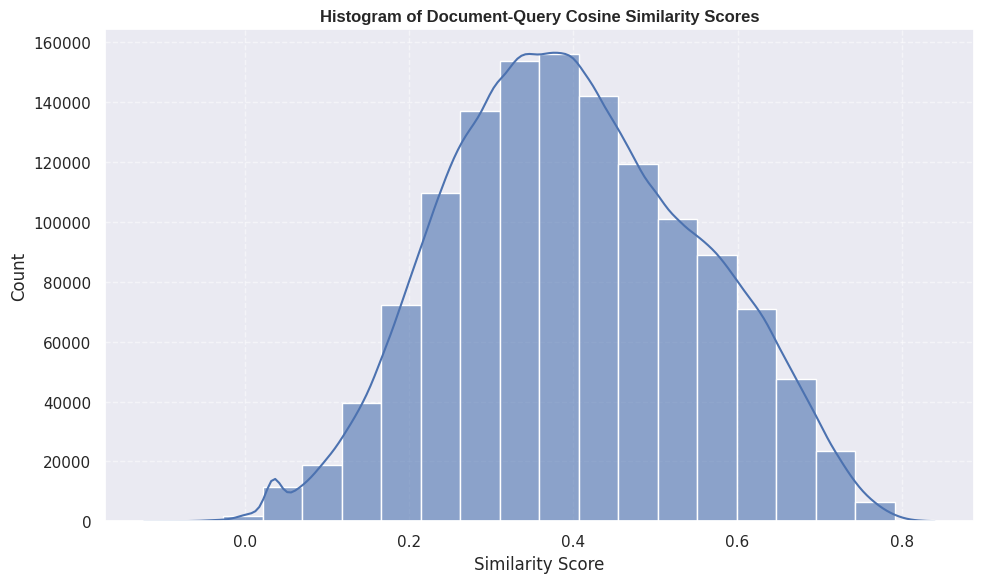

In [7]:
# eda on score results
topn_plot(scored_documents, 
          title="Histogram of Document-Query Cosine Similarity Scores")

In [8]:
# function to sample and save

def save_samples(df, all_articles, all_dates, all_sources, n_quantiles=20, n_samples=50, random_state=123, 
                 file_name="validation_samples"):
    """
    Samples articles from a DataFrame based on score quantiles, retrieves additional metadata,
    adds a placeholder for manual labeling, and saves the samples to a CSV.

    Args:
        df (pd.DataFrame): DataFrame containing at least 'corpus_id' and 'score' columns.
                           'score' is assumed to be the cosine similarity score.
        all_articles (list or array-like): A list/array where all_articles[corpus_id] gives the article text.
        all_dates (list or array-like): A list/array where all_dates[corpus_id] gives the article date.
        all_sources (list or array-like): A list/array where all_sources[corpus_id] gives the article source.
        n_quantiles (int, optional): Number of quantiles to divide the scores into. Defaults to 20.
        n_samples (int, optional): Number of samples to take from each quantile. Defaults to 50.
        random_state (int, optional): Seed for random sampling for reproducibility. Defaults to 123.
        file_name (str, optional): Name of the CSV file to save (without extension).
                                    Defaults to "validation_samples".

    Returns:
        pd.DataFrame: The sampled DataFrame with added metadata and manual label placeholder.
    """

    # folder to store samples
    samples_dir = "data/article_samples/"
    if not os.path.exists(samples_dir):
        os.makedirs(samples_dir)

    # making file path
    file_path = os.path.join(samples_dir, file_name)

    # 1. Separating into quantiles (20) using qcut
    df['quantile'] = pd.qcut(df['score'], 
                           q=n_quantiles, 
                           labels=False,  # labels=False assigns quantile integers
                           duplicates='drop') +1    # duplicates='drop' prevents ValueErrors arising from non-unique bin edges (common with many identical scores);
                            # +1 to make quantiles 1-10 instead of 0-9
   

    # 2. Grouping and sampling for each quantile
    # group_keys=False prevents 'quantile' from becoming an index after grouping
    df_sampled = df.groupby('quantile', 
                            group_keys=False).sample(n=n_samples,
                                                     random_state=random_state).sort_values('quantile',
                                                                                            ascending=False)

    # 3. Retrieving article text, date, and source and adding it to the samples dataframe
    df_sampled['date'] = df_sampled['corpus_id'].apply(lambda idx: all_dates[idx])
    df_sampled['source'] = df_sampled['corpus_id'].apply(lambda idx: all_sources[idx])
    df_sampled['article_text'] = df_sampled['corpus_id'].apply(lambda idx: all_articles[idx]) # Renamed to avoid 'article' being ambiguous

    # 4. Add a placeholder for the manual label
    # Use numpy.nan for numerical columns where 'None' might cause issues, or just None for object dtype
    df_sampled['is_relevant_manual'] = np.nan # Placeholder for manual 0/1 (Not Relevant/Relevant)

    # 5. Saving to local as csv
    # Ensure all desired columns are present for saving. The current df_sampled will contain them.
    df_sampled.to_csv(file_path + '.csv', index=False, encoding="utf-8-sig")

    print(f"Successfully sampled {len(df_sampled)} articles and saved to {file_path}.csv")

    return df_sampled

In [9]:
save_samples(scored_documents, all_articles, all_dates, all_sources, file_name="validation_samples")

Successfully sampled 1000 articles and saved to data/article_samples/validation_samples.csv


,corpus_id,score,quantile,date,source,article_text,is_relevant_manual
33455,120881,0.691093,20,1838-09-22,star,TO THE EDITORS OF THE NORTHERN STAR. GENTLEME...,NaN
29304,359889,0.696746,20,1842-07-23,star,ANOTHER DEFEAT OF THE LEAGUE.—Last Monday nigh...,NaN
49003,161659,0.673364,20,1842-09-17,star,"MANCHESTER, WEDNESDAY NIGHT, SEPT. 14TH.— Yest...",NaN
4063,870148,0.756822,20,1841-11-13,star,DAVENTRY.—A meeting was called on Saturday eve...,NaN
58493,979147,0.663989,20,1851-10-18,leader,Mr. Hume addressed a composite meeting of pers...,NaN
...,...,...,...,...,...,...,...
1252744,277617,0.141461,1,1848-03-11,star,THE LAND. The following is a list of the prin...,NaN
1294540,1048617,0.034556,1,1852-07-17,leader,.................................................,NaN
1270422,367426,0.115083,1,1842-12-03,star,"A LITTLE BOY was walking along a road, and hea...",NaN
1301201,1154158,-0.066795,1,1885-05-15,circ,CHILES CULTIVAR The following is a list of th...,NaN


## Samples checked, validation dataset obtained! Now to ascertain an appropriate semantic score cut-off.
Steps:
1. load in checked validation samples
2. plot how annotated relevance changes with score
3. pick some cut-off thresholds
4. for each potential cut-off, calculate precisoin/accuracy/f1 score
5. compare f1 score to determine the most appropriate one to move forward with

In [10]:
# loading my checked validation set
validation_df = pd.read_csv("./data/article_samples/validation_samples_checked.csv")
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   corpus_id           1000 non-null   int64  
 1   score               1000 non-null   float64
 2   quantile            1000 non-null   int64  
 3   date                1000 non-null   object 
 4   source              1000 non-null   object 
 5   article_text        1000 non-null   object 
 6   is_relevant_manual  1000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


In [11]:
# some descriptive stats
validation_df['score'].describe()

count    1000.000000
mean        0.398810
std         0.153464
min        -0.066795
25%         0.288704
50%         0.390723
75%         0.508685
max         0.774402
Name: score, dtype: float64

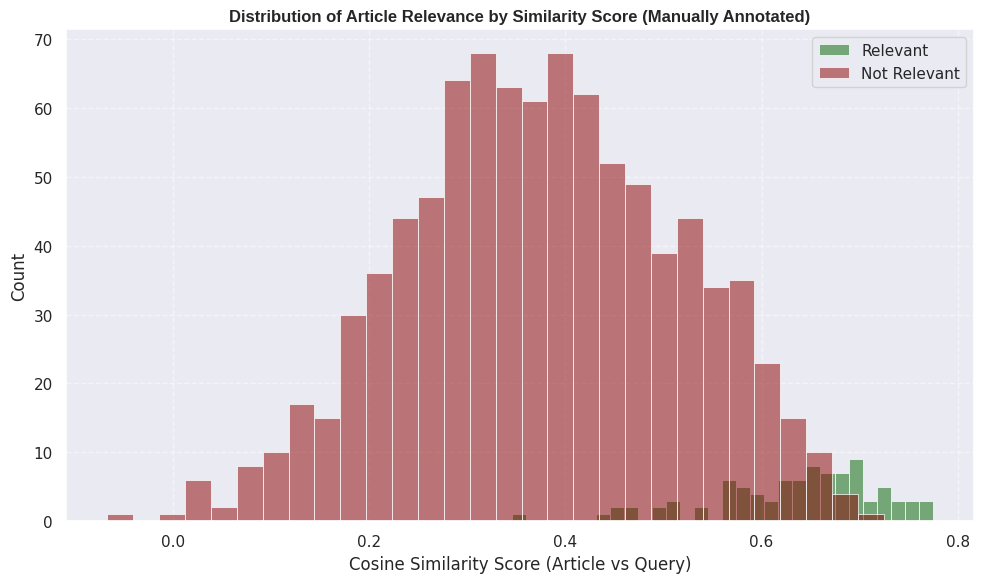

In [140]:
# visualising with a histogram
relevant = validation_df[validation_df["is_relevant_manual"] == 1]
not_relevant = validation_df[validation_df["is_relevant_manual"] == 0]

# Plot overlaid histogram
plt.figure(figsize=(10, 6))
sns.set_theme()
sns.histplot(relevant["score"], bins=30, color="darkgreen", label="Relevant", kde=False, alpha=0.5, linewidth=0.5)
sns.histplot(not_relevant["score"], bins=30, color="darkred", label="Not Relevant", kde=False, alpha=0.5, linewidth=0.5)

# Customize the plot
plt.title("Distribution of Article Relevance by Similarity Score (Manually Annotated)", 
          fontweight='bold',
         fontname='Liberation Sans')
plt.xlabel("Cosine Similarity Score (Article vs Query)")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

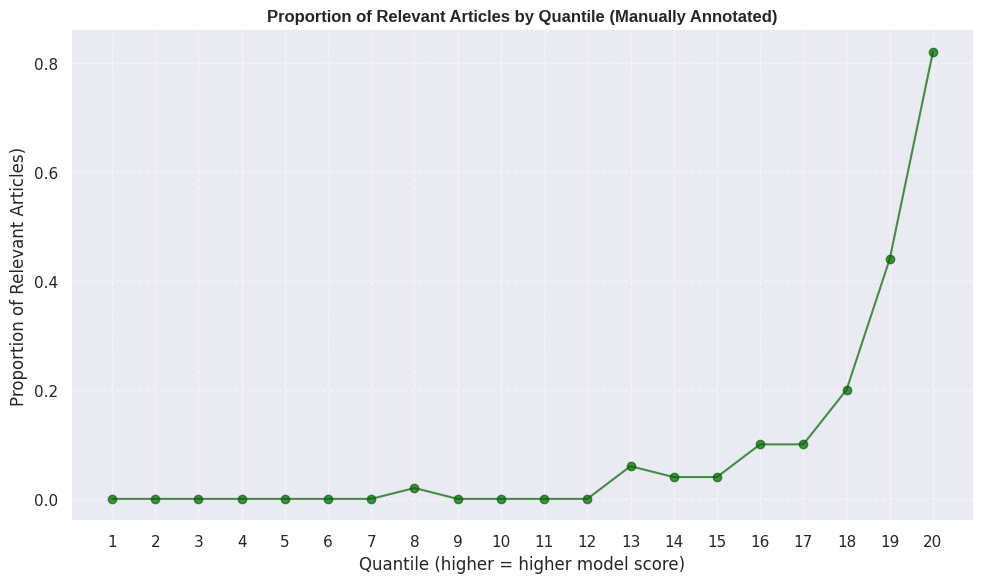

In [137]:
# calculating relevance proportion by quantile
relevance_by_quantile = (
    validation_df.groupby('quantile')['is_relevant_manual']
    .mean()  # mean of 0s and 1s gives the proportion of 1s
    .sort_index(ascending=False)  # optional: show quantiles from 20 down to 1
)

# plotting it
plt.figure(figsize=(10, 6))
plt.plot(relevance_by_quantile.index, relevance_by_quantile.values, marker='o', color='darkgreen', alpha = 0.7)
plt.title('Proportion of Relevant Articles by Quantile (Manually Annotated)',
          fontweight='bold',
         fontname='Liberation Sans')
plt.xlabel('Quantile (higher = higher model score)')
plt.ylabel('Proportion of Relevant Articles)')
plt.xticks(relevance_by_quantile.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
relevance_by_quantile

quantile
20    0.82
19    0.44
18    0.20
17    0.10
16    0.10
15    0.04
14    0.04
13    0.06
12    0.00
11    0.00
10    0.00
9     0.00
8     0.02
7     0.00
6     0.00
5     0.00
4     0.00
3     0.00
2     0.00
1     0.00
Name: is_relevant_manual, dtype: float64

This suggests that most of the action is happening in deciles 16-20. Now, I'm bringing back scored_documents, finding out bin edges (where each of the 20 quantiles starts and ends), and using that to inform my cut-off threshold candidates.

In [15]:
# splitting again. could've done this earlier but here we are
_, bins = pd.qcut(scored_documents['score'],
                  q=20,
                  labels=False,
                  retbins=True,
                  duplicates='drop')

print(f"The array below shows the minimum score ({bins[0]}), maximum score ({bins[-1]}), and bin edges in between.")
bins

The array below shows the minimum score (-0.12255184352397919), maximum score (0.8397210836410522), and bin edges in between.


array([-0.12255184,  0.15987019,  0.20647372,  0.23844053,  0.2646421 ,
        0.28839517,  0.31021259,  0.33098051,  0.35101418,  0.37109455,
        0.3911227 ,  0.41129468,  0.43265921,  0.45578844,  0.48093253,
        0.50895108,  0.53979667,  0.57311558,  0.61069098,  0.65809922,
        0.83972108])

Since quantile 16 has 10% relevance and quantiles below that are arguably negligible, I'll take the lower bound of quantile 16 as the minimum candidate threshold I'll test for.

In [16]:
print(f"Score at which threshold candidate starts: {bins[15]} (lower bound of quantile 16).")
start_threshold = bins[15] - 0.01 # -0.01 for safety buffer
print(f"Score at which threshold candidate ends: {bins[-1]} (max score).")
end_threshold = bins[-1]

Score at which threshold candidate starts: 0.5089510828256607 (lower bound of quantile 16).
Score at which threshold candidate ends: 0.8397210836410522 (max score).


In [17]:
# i will test 100 points in this window.
potential_thresholds = np.linspace(start_threshold,
                                   end_threshold,
                                   100)

# experimenting also with f-beta, which allows me to adjust how precision/recall are weighted
beta_value = 0.5 # Define your beta for prioritizing precision (e.g., 0.5 for precision twice as important)


# initiating list for results
threshold_results = []

# iterating through potential thresholds to calculate precision/accuracy metrics
# using scikitlearn's handy precision_score, recall_score, f1_score :D
for threshold in potential_thresholds:
    # assigning relevant/not relevant based on threshold currently being tested
    validation_df['predicted_relevant'] = (validation_df['score'] >= threshold).astype(int)

    precision = sklearn.metrics.precision_score(validation_df['is_relevant_manual'],
                                validation_df['predicted_relevant'],
                                zero_division=0)
    recall = sklearn.metrics.recall_score(validation_df['is_relevant_manual'], 
                          validation_df['predicted_relevant'], 
                          zero_division=0)
    f1 = sklearn.metrics.f1_score(validation_df['is_relevant_manual'], 
                  validation_df['predicted_relevant'], 
                  zero_division=0)
    fbeta = sklearn.metrics.fbeta_score(validation_df['is_relevant_manual'], 
                        validation_df['predicted_relevant'], 
                        beta=beta_value, 
                        zero_division=0)


    # adding metrics to da list
    threshold_results.append({'threshold': threshold, 
                              'precision': precision,
                              'recall': recall, 
                              'f1_score': f1,
                              f"f{beta_value}_score": fbeta})

threshold_results_df = pd.DataFrame(threshold_results)
    

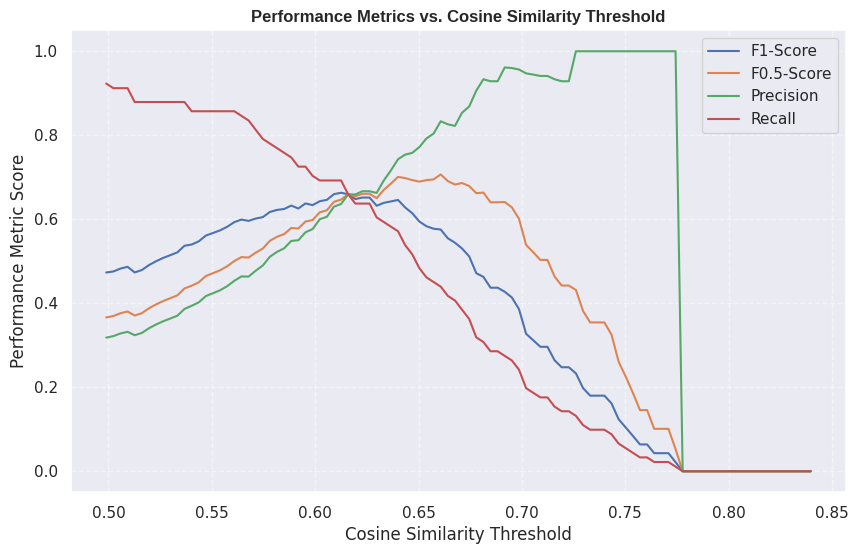

In [90]:
# visualising metrics by threshold score
plt.figure(figsize=(10, 6))
sns.lineplot(x='threshold', 
             y='f1_score', 
             data=threshold_results_df, 
             label='F1-Score')
sns.lineplot(x='threshold', 
             y=f"f{beta_value}_score", 
             data=threshold_results_df, label=(f"F{beta_value}-Score"))
sns.lineplot(x='threshold', 
             y='precision', 
             data=threshold_results_df, 
             label='Precision')
sns.lineplot(x='threshold', 
             y='recall', 
             data=threshold_results_df, 
             label='Recall')

plt.title('Performance Metrics vs. Cosine Similarity Threshold',
          fontweight='bold',
         fontname='Liberation Sans')
plt.xlabel('Cosine Similarity Threshold')
plt.ylabel('Performance Metric Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [19]:
threshold_results_df.head()

,threshold,precision,recall,f1_score,f0.5_score
0,0.498951,0.318182,0.923077,0.473239,0.366173
1,0.502393,0.321705,0.912088,0.475645,0.369546
2,0.505835,0.328063,0.912088,0.482558,0.376247
3,0.509277,0.332000,0.912088,0.486804,0.380385
4,0.512720,0.323887,0.879121,0.473373,0.370714


In [20]:
# if going by peak f1 score:
optimal_f1_row = threshold_results_df.loc[threshold_results_df['f1_score'].idxmax()]
print(f"\nOptimal Threshold (max F1-Score): {optimal_f1_row['threshold']:.4f}")
print(f"Corresponding F1-Score: {optimal_f1_row['f1_score']:.4f}")
print(f"Corresponding Precision: {optimal_f1_row['precision']:.4f}")
print(f"Corresponding Recall: {optimal_f1_row['recall']:.4f}")

# if going by peak f0.5 score (precision twice as important as recall):
optimal_fbeta_row = threshold_results_df.loc[threshold_results_df['f0.5_score'].idxmax()]
print(f"\nOptimal Threshold (max F0.5-Score): {optimal_fbeta_row['threshold']:.4f}")
print(f"Corresponding F1-Score: {optimal_fbeta_row['f1_score']:.4f}")
print(f"Corresponding Precision: {optimal_fbeta_row['precision']:.4f}")
print(f"Corresponding Recall: {optimal_fbeta_row['recall']:.4f}")

chosen_threshold = optimal_fbeta_row['threshold']
print(chosen_threshold)


Optimal Threshold (max F1-Score): 0.6125
Corresponding F1-Score: 0.6632
Corresponding Precision: 0.6364
Corresponding Recall: 0.6923

Optimal Threshold (max F0.5-Score): 0.6607
Corresponding F1-Score: 0.5755
Corresponding Precision: 0.8333
Corresponding Recall: 0.4396
0.6607307801824627


## Taking the chosen threshold (where fbeta peaks) as a similarity score cut-off filter, now I'm finally filtering my corpus to the subset of articles to pass to the NER stage.

In [54]:
print(f"Number of articles before subsetting: {len(scored_documents)}")

# subsetting and dropping quantile column because i don't need it anymore
print(f"Subsetting corpus to articles with similarity score > threshold that optimises f-beta score...")
subset = scored_documents[scored_documents['score'] >= chosen_threshold].drop(columns='quantile') 

print(f"Number of articles dropped: {len(scored_documents) - len(subset)}")
print(f"Number of articles in subset: {len(subset)}")
print(f"Articles taken on to NER stage form {((len(subset)/len(scored_documents))*100):.2f}% of the original corpus.")

Number of articles before subsetting: 1301232
Subsetting corpus to articles with similarity score > threshold that optimises f-beta score...
Number of articles dropped: 1239147
Number of articles in subset: 62085
Articles taken on to NER stage form 4.77% of the original corpus.


## Some descriptive stats for subset

In [61]:
# adding article metadata to subset
subset['date'] = subset['corpus_id'].apply(lambda idx: all_dates[idx])
subset['source'] = subset['corpus_id'].apply(lambda idx: all_sources[idx])
subset['article_text'] = subset['corpus_id'].apply(lambda idx: all_articles[idx])

# changing source from string to category
subset['source'] = subset['source'].astype("category")

print(subset.head())
print(subset['score'].describe())

   corpus_id     score       date source  \
0     178361  0.839721 1838-09-08   star   
1     454650  0.839554 1842-02-26   star   
2     798998  0.832106 1839-05-04   star   
3     709266  0.830941 1842-04-30   star   
4     833213  0.828974 1841-10-02   star   

                                        article_text  
0  Preparatory to a Demonstration in favor of the...  
1  The London Chartists are auxiously invited to ...  
2  PUBLIC MEETING. - In this small village we had...  
3  Islington.—A public open air meeting was held ...  
4  LEEDS.—On Sunday last, in the absence of Mr. M...  
count    62085.000000
mean         0.701195
std          0.031241
min          0.660731
25%          0.675915
50%          0.694403
75%          0.720133
max          0.839721
Name: score, dtype: float64


In [126]:
# subset's article count by source
source_counts = subset['source'].value_counts().reset_index()
source_counts.columns = ['source', 'count']
source_counts['prop'] = source_counts['count'] / source_counts['count'].sum()
source_counts

,source,count,prop
0,star,60033,0.966949
1,leader,1829,0.029460
2,repo,185,0.002980
3,tomahawk,25,0.000403
4,ewj,7,0.000113
5,circ,6,0.000097


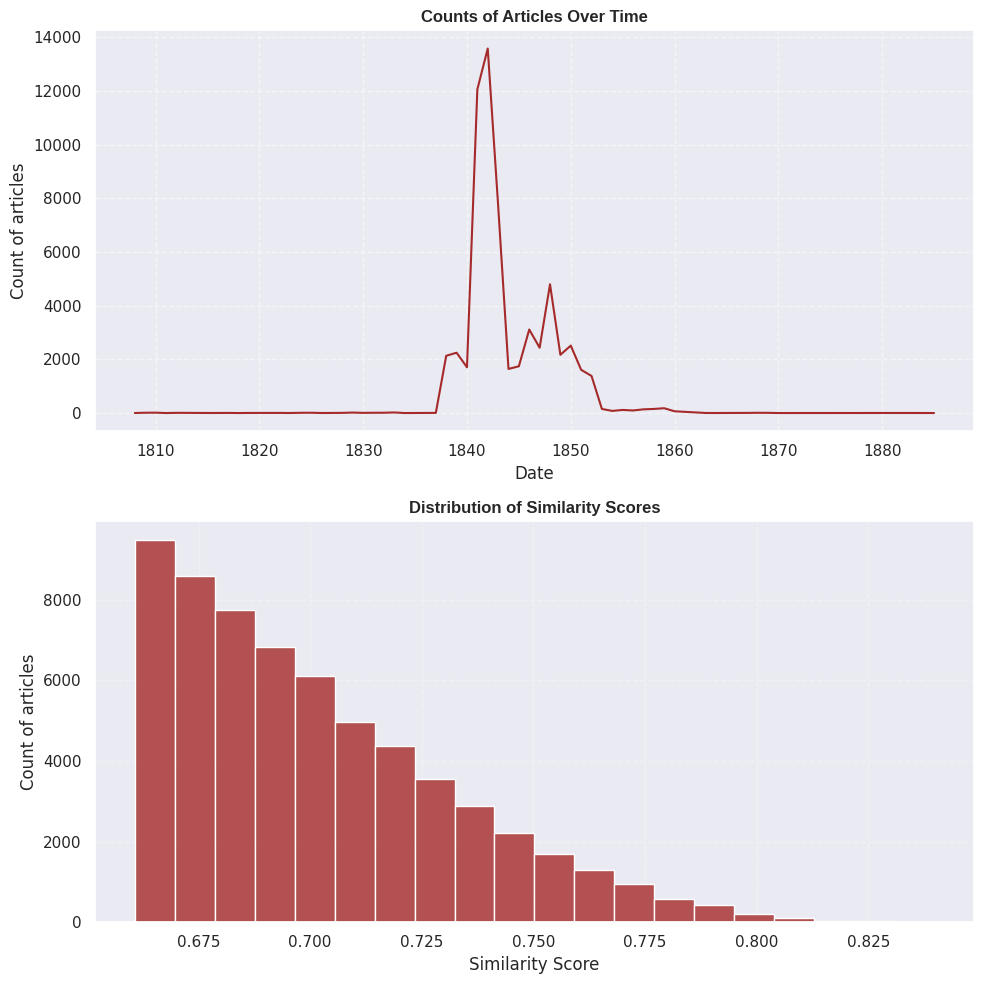

In [154]:
# plotting some EDA

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
sns.set_theme()


# 1. LINE CHART of articles over time
subset['year'] = subset['date'].dt.year
subset_by_year = subset.groupby('year').size().reset_index(name='count')

sns.lineplot(data=subset_by_year,
             x='year', 
             y='count',
             color='brown',
             ax=axes[0])
axes[0].set_title("Counts of Articles Over Time", 
                     fontweight='bold',
                    fontname='Liberation Sans')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Count of articles")
axes[0].grid(True, linestyle='--', alpha=0.5)


# 2. HISTOGRAM of similarity scores
sns.histplot(data=subset, 
             x='score', 
             bins=20, 
             color='brown', 
             alpha=0.8, 
             ax=axes[1])
axes[1].grid(True, linestyle='--', alpha=0.3)
axes[1].set_title("Distribution of Similarity Scores", 
                     fontweight='bold',
                    fontname='Liberation Sans')
axes[1].set_xlabel("Similarity Score")
axes[1].set_ylabel("Count of articles")

plt.tight_layout()
plt.show()

## Saving subset df 

In [155]:
subset.to_csv("data/ner_subset.csv",  index=False, encoding="utf-8-sig")